In [1]:
import glob

# Return training image file names, grouped in cars and not cars.
def get_training_image_files():
    car_images = glob.glob('dataset/vehicles/**/*.png')
    notcar_images = glob.glob('dataset/non-vehicles/**/*.png')
    print("There are %d car images and %d non-car images"
          % (len(car_images), len(notcar_images)))
    return car_images, notcar_images

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Read a png or jpg image file and make sure the value range is [0, 255]
def read_image_file(filename):
    img = mpimg.imread(filename)
    if filename.endswith('.png'):
        # png between 0 and 1
        return (img*255).astype(np.uint8)
    else:
        return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image
# Have this function call bin_spatial() and color_hist()
def single_image_features(image, cspace='RGB', orient=9,
                          pix_per_cell=8, cell_per_block=2, hog_channel=0,
                          spatial_size=(16, 16),
                          hist_bins=32, hist_range=(0, 256), debug=False):
    image = cv2.resize(image, (64, 64))
    image = image.astype(np.float32)/255
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    if debug:
        print('feature_image', feature_image.shape, np.mean(feature_image), 'spatial_size', spatial_size)
        print('hog_features mean', np.mean(hog_features), hog_features.shape)
        print('spatial_features mean', np.mean(spatial_features), spatial_features.shape, 'cspace', cspace)
        print('hist_features mean', np.mean(hist_features), hist_features.shape)
    return np.concatenate((hog_features, spatial_features, hist_features))
  
def extract_features(imgs, cspace='RGB', orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=(16, 16), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = read_image_file(file)
        image_features = single_image_features(image, cspace=cspace, orient=orient,
                                               pix_per_cell=pix_per_cell,
                                               cell_per_block=cell_per_block,
                                               hog_channel=hog_channel,
                                               spatial_size=spatial_size,
                                               hist_bins=hist_bins, hist_range=hist_range)
        features.append(image_features)
    # Return list of feature vectors
    return features


In [3]:
def test_image_file():
    cars, notcars = get_training_image_files()
    car_img = read_image_file(cars[0])
    notcar_img = read_image_file(notcars[0])
    print('car', car_img.shape, 'notcar', notcar_img.shape)
    
test_image_file()

There are 8792 car images and 8968 non-car images
car (64, 64, 3) notcar (64, 64, 3)


In [4]:
import pickle
import os.path

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 64

def extract_training_image_features(car_features_output_filename,
                                    notcar_features_output_filename,
                                    force_generate=False, sample_size=-1):
    # Use cached feature calculation outputs
    if (os.path.isfile(car_features_output_filename)
        and os.path.isfile(notcar_features_output_filename) and not force_generate):
        t=time.time()
        with open(car_features_output_filename, 'rb') as f:
            car_features = np.load(f)
        with open(notcar_features_output_filename, 'rb') as f:
            notcar_features = np.load(f)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to read cached HOG features with car_features',
              len(car_features), 'notcar_features', len(notcar_features),
              'features.shape', car_features[0].shape)
        return car_features, notcar_features
    
    # Divide up into cars and notcars
    cars, notcars = get_training_image_files()

    # Reduce the sample size because HOG features are slow to compute
    # The quiz evaluator times out after 13s of CPU time
    if sample_size > 0:
        cars = cars[0:sample_size]
        notcars = notcars[0:sample_size]

    t=time.time()
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_size=(spatial, spatial),
                                    hist_bins=histbin, hist_range=(0, 256))
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_size=(spatial, spatial),
                                       hist_bins=histbin, hist_range=(0, 256))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features with car_features',
          len(car_features), 'notcar_features', len(notcar_features),
          'features.shape', car_features[0].shape)
    
    with open(car_features_output_filename,'wb') as f:
        np.save(f, car_features)
    with open(notcar_features_output_filename,'wb') as f:
        np.save(f, notcar_features)
    return car_features, notcar_features


In [5]:
car_features, notcar_features = extract_training_image_features(
    'car_features.saved', 'notcar_features.saved', force_generate=False, sample_size=-1)

0.39 Seconds to read cached HOG features with car_features 8792 notcar_features 8968 features.shape (13848,)


In [6]:
# Train a SVC model using car/notcar features
def train_svc(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 10000)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

In [7]:
svc, X_scaler = train_svc(car_features, notcar_features)

Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 13848
6.45 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  0.  1.]
0.00182 Seconds to predict 10 labels with SVC


In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_image_features(test_img, cspace=colorspace, orient=orient,
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel, spatial_size=(spatial, spatial),
                                         hist_bins=histbin, hist_range=hist_range)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print('search_windows', test_features.shape, features.shape)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            #single_image_features(test_img, cspace=colorspace, orient=orient,
            #                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            #                             hog_channel=hog_channel, spatial_size=(spatial, spatial),
            #                             hist_bins=histbin, hist_range=hist_range, debug=True)
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [9]:
def search_for_car_bounding_boxes(image, xy_window=(64, 64), y_start_stop=[400,720]):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial, hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    return hot_windows

def multiscale_search_for_car_bounding_boxes(image, report=False):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    t = time.time()
    hot_windows = []
    windows1 = search_for_car_bounding_boxes(image, xy_window=(128, 128), y_start_stop=[400,656])
    windows2 = search_for_car_bounding_boxes(image, xy_window=(64, 64), y_start_stop=[400, 560])
    windows3 = search_for_car_bounding_boxes(image, xy_window=(32, 32), y_start_stop=[400,500])
    hot_windows.extend(windows1)
    hot_windows.extend(windows2)
    hot_windows.extend(windows3)
    t = time.time() - t
    if report:
        print("Using %.3f second: %d hot windows in total: %d 32x32 %d 64x64 %d 128x128"
              % (t, len(hot_windows), len(windows3), len(windows2),
                 len(windows1)))
    return hot_windows

figure_id = 1

def show_hot_windows(image, hot_windows, filename):
    global figure_id
    draw_image = np.copy(image)
    #print('hot_windows', len(hot_windows))
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    #print('window_img', window_img.shape)
    plt.figure(figure_id)
    plt.title('Car bounding boxes for ' + filename)
    figure_id += 1
    plt.imshow(window_img)
    #mpimg.imsave('window_img.jpg', window_img)

def test_regular_multiscale_search(filename):
    image = read_image_file(filename)
    hot_windows = multiscale_search_for_car_bounding_boxes(image, report=True)
    #hot_windows = search_for_car_bounding_boxes(image, xy_window=(128, 128), y_start_stop=[400,656])
    show_hot_windows(image, hot_windows)

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_with_scale(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    #print('img_tosearch', img_tosearch.shape, np.mean(img_tosearch))
    #print('ctrans_tosearch', ctrans_tosearch.shape, np.mean(ctrans_tosearch))
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1)) 
            #print(hog_features.shape, spatial_features.shape, hist_features.shape, test_features.shape)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart),
                                    (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return window_list

'''
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 64
'''

def multiscale_find_cars(img, report=False):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #img = img.astype(np.float32)/255
    t0=time.time()
    hot_windows = []
    scales = [0.5, 1.2, 1.8, 2.7]
    sizes = [int(i*64) for i in scales]
    #windows_scale_1 = find_cars_with_scale(img, 420, 500, scales[0], svc, X_scaler,
    #                                       orient, pix_per_cell, cell_per_block, spatial,
    #                                       histbin)
    #hot_windows.extend(windows_scale_1)
    #t1 = time.time()
    windows_scale_2 = find_cars_with_scale(img, 400, 500, scales[1], svc, X_scaler,
                                           orient, pix_per_cell, cell_per_block, spatial,
                                           histbin)
    hot_windows.extend(windows_scale_2)
    t2 = time.time()
    windows_scale_3 = find_cars_with_scale(img, 400, 580, scales[2], svc, X_scaler,
                                           orient, pix_per_cell, cell_per_block, spatial,
                                           histbin)
    hot_windows.extend(windows_scale_3)
    t3 = time.time()
    windows_scale_4 = find_cars_with_scale(img, 400, 660, scales[3], svc, X_scaler,
                                           orient, pix_per_cell, cell_per_block, spatial,
                                           histbin)
    hot_windows.extend(windows_scale_4)
    t4 = time.time()
    if report:
        print("""Using %.4f second (%.4f %.4f %.4f): %d hot windows in total: 
        %d %dx%d %d %dx%d %d %dx%d"""
              % (t4-t0, t2-t0, t3-t2, t4-t3, len(hot_windows),
                 #len(windows_scale_1), sizes[0], sizes[0],
                 len(windows_scale_2), sizes[1], sizes[1],
                 len(windows_scale_3), sizes[2], sizes[2],
                 len(windows_scale_4), sizes[3], sizes[3]))
    return hot_windows

def test_multiscale_find_cars(filename):
    image = read_image_file(filename)
    hot_windows = multiscale_find_cars(image, report=True)
    #hot_windows = find_cars_with_scale(image, 400, 656, 2.0, svc, X_scaler,
    #                                       orient, pix_per_cell, cell_per_block, spatial,
    #                                       histbin)
    show_hot_windows(image, hot_windows, filename)


Using 0.8878 second (0.4756 0.2508 0.1614): 61 hot windows in total: 
        30 76x76 28 115x115 3 172x172
Using 0.6512 second (0.2172 0.2789 0.1551): 0 hot windows in total: 
        0 76x76 0 115x115 0 172x172
Using 0.6571 second (0.2241 0.2525 0.1805): 10 hot windows in total: 
        9 76x76 1 115x115 0 172x172
Using 0.6379 second (0.2212 0.2513 0.1653): 57 hot windows in total: 
        28 76x76 23 115x115 6 172x172
Using 0.6988 second (0.2524 0.2887 0.1577): 54 hot windows in total: 
        32 76x76 20 115x115 2 172x172
Using 0.6414 second (0.2135 0.2635 0.1644): 64 hot windows in total: 
        36 76x76 28 115x115 0 172x172
Using 0.6136 second (0.2143 0.2399 0.1594): 4 hot windows in total: 
        4 76x76 0 115x115 0 172x172


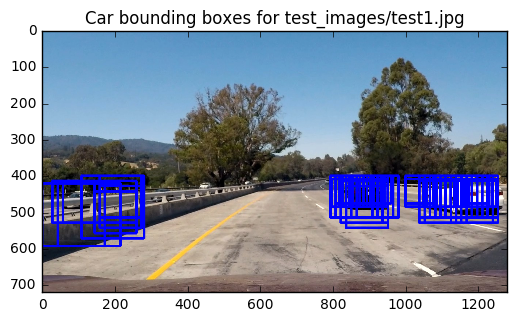

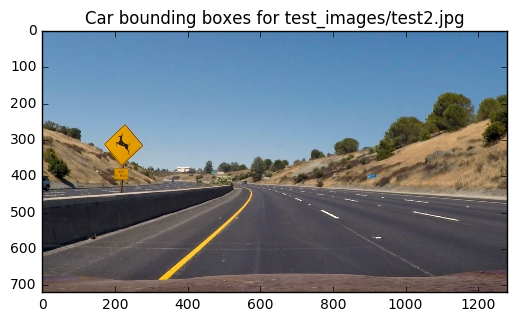

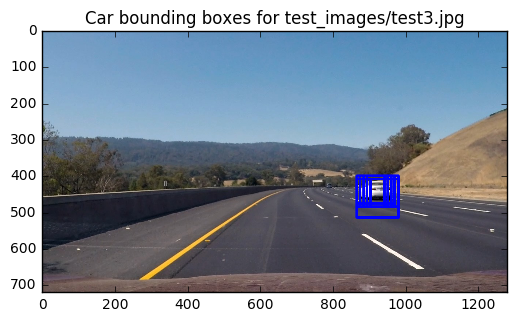

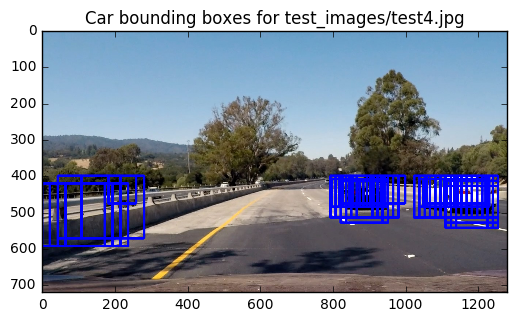

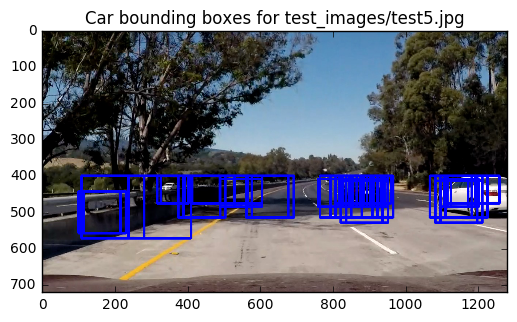

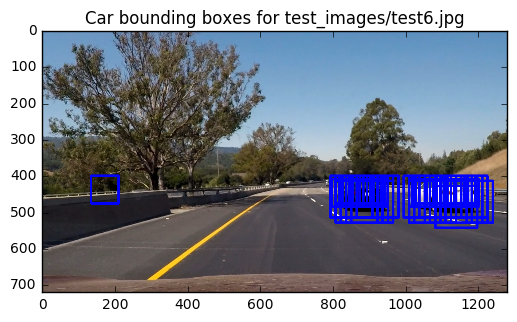

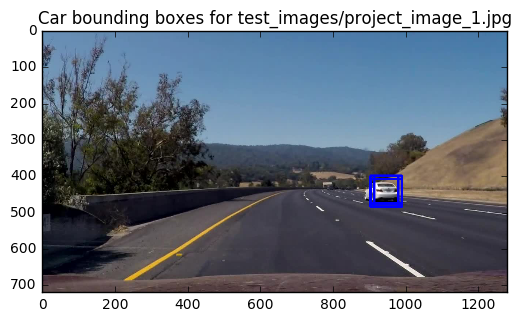

In [11]:
%matplotlib inline

figure_id = 1

#test_on_image_file('test_images/test4.jpg')
test_multiscale_find_cars('test_images/test1.jpg')
test_multiscale_find_cars('test_images/test2.jpg')
test_multiscale_find_cars('test_images/test3.jpg')
test_multiscale_find_cars('test_images/test4.jpg')
test_multiscale_find_cars('test_images/test5.jpg')
test_multiscale_find_cars('test_images/test6.jpg')
test_multiscale_find_cars('test_images/project_image_1.jpg')


In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label

def generate_heatmap(image, hot_windows):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return heatmap, labels

# Merge overlapping bounding boxes (Malisiewicz et al.)
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

# Generate bounding boxes from labels output
def generate_bounding_boxes_from_labels(labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #bboxes.append(bbox)
        bboxes.append([np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)])
    np_bboxes = np.array(bboxes)
    merged_boxes = non_max_suppression_fast(np_bboxes, 0.6)
    #merged_boxes = np_bboxes
    bboxes = []
    for mb in merged_boxes:
        bbox = ((mb[0], mb[1]), (mb[2], mb[3]))
        bboxes.append(bbox)
    return bboxes

def draw_labeled_bboxes(img, bboxes):
    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def test_heatmap_labels(filename):
    image = read_image_file(filename)
    hot_windows = multiscale_find_cars(image, report=False)
    heatmap, labels = generate_heatmap(image, hot_windows)
    bboxes = generate_bounding_boxes_from_labels(labels)
    print(len(bboxes), 'boxes', bboxes, 'hot_windows', len(hot_windows))
    print(type(labels), labels[0].shape, labels[1])
    draw_img = draw_labeled_bboxes(np.copy(image), bboxes)
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')


3 boxes [((43, 414), (272, 571)), ((1036, 400), (1246, 528)), ((806, 400), (958, 528))] hot_windows 61
<class 'tuple'> (720, 1280) 3


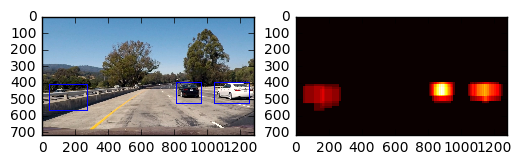

In [13]:
test_heatmap_labels('test_images/test1.jpg')

0 boxes [] hot_windows 0
<class 'tuple'> (720, 1280) 0


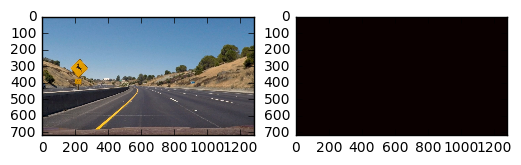

In [14]:
test_heatmap_labels('test_images/test2.jpg')

1 boxes [((864, 400), (967, 484))] hot_windows 10
<class 'tuple'> (720, 1280) 1


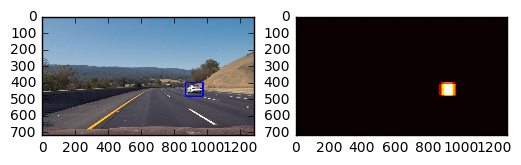

In [15]:
test_heatmap_labels('test_images/test3.jpg')

3 boxes [((43, 400), (235, 592)), ((1036, 400), (1251, 542)), ((806, 400), (963, 514))] hot_windows 57
<class 'tuple'> (720, 1280) 3


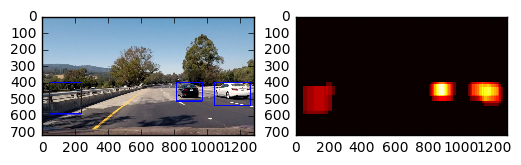

In [16]:
test_heatmap_labels('test_images/test4.jpg')

7 boxes [((115, 443), (214, 557)), ((1080, 400), (1208, 514)), ((792, 400), (949, 514)), ((326, 400), (408, 514)), ((528, 400), (603, 484)), ((489, 409), (502, 475)), ((412, 400), (487, 475))] hot_windows 54
<class 'tuple'> (720, 1280) 7


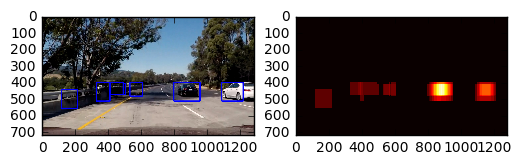

In [17]:
test_heatmap_labels('test_images/test5.jpg')

2 boxes [((1008, 400), (1222, 528)), ((806, 400), (963, 528))] hot_windows 64
<class 'tuple'> (720, 1280) 2


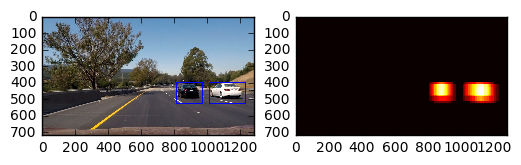

In [18]:
test_heatmap_labels('test_images/test6.jpg')

1 boxes [((912, 409), (977, 475))] hot_windows 4
<class 'tuple'> (720, 1280) 1


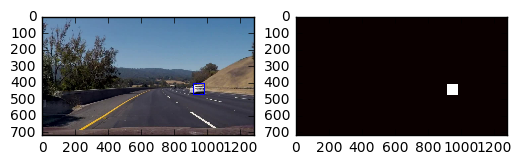

In [19]:
test_heatmap_labels('test_images/project_image_1.jpg')

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import sqrt

class BoxInfo(object):
    def __init__(self, box, frame_id):
        self.box = box
        self.last_frame_id = frame_id
        self.appearances = 1
        
    def update(self, box, frame_id):
        self.box = box
        self.last_frame_id = frame_id
        self.appearances += 1

    def report(self):
        print('box', self.box, 'last_frame_id',
              self.last_frame_id, 'appearances', self.appearances)
        
# A tracker for all bounding boxes in a video.
class BBoxTracker(object):
    def __init__(self, overlap_threshold=0.5, box_drop_after_frames=2, appear_draw_after_frames=2):
        self.reset(overlap_threshold, box_drop_after_frames, appear_draw_after_frames)
    
    def reset(self, overlap_threshold=0.5, box_drop_after_frames=2, appear_draw_after_frames=2):
        self.overlap_threshold = overlap_threshold
        self.tracked_boxes = []
        self.frame_counter = 0
        # If a bounding box doesn't reappear after this number of frames,
        # just drop it.
        self.box_drop_after_frames = box_drop_after_frames
        # If a bounding box has appeared in this number of frames, draw it.
        self.appear_draw_after_frames = appear_draw_after_frames
        
    def increment_frame_counter(self):
        self.frame_counter += 1
    
    # The ratio of the overlapping area to the smaller box
    def overlap_ratio(self, box1, box2):
        b1_x1 = box1[0][0]
        b1_y1 = box1[0][1]
        b1_x2 = box1[1][0]
        b1_y2 = box1[1][1]
        b1_area = (b1_x2-b1_x1)*(b1_y2-b1_y1)
        b2_x1 = box2[0][0]
        b2_y1 = box2[0][1]
        b2_x2 = box2[1][0]
        b2_y2 = box2[1][1]
        b2_area = (b2_x2-b2_x1)*(b2_y2-b2_y1)
        # SI = Max(0, Max(XA2, XB2) - Min(XA1, XB1)) * Max(0, Max(YA2, YB2) - Min(YA1, YB1))
        intersection = (max(0, min(b1_x2, b2_x2) - max(b1_x1, b2_x1))
                        * max(0, min(b1_y2, b2_y2) - max(b1_y1, b2_y1)))
        base_area = min(b1_area, b2_area)
        ratio = 0.5 * ((intersection / b1_area) + (intersection / b2_area))
        return ratio
        
    # For a new bounding box, check if it can be used to update an existing one
    # or added as a new one.
    def update_box(self, box):
        updated = False
        for existing_box in self.tracked_boxes:
            ratio = self.overlap_ratio(box, existing_box.box)
            if ratio >= self.overlap_threshold:
                #print('update_box with ', box, 'with ratio', ratio, 'at frame', self.frame_counter)
                existing_box.update(box, self.frame_counter)
                updated = True
                break
        if not updated:
            new_box = BoxInfo(box, self.frame_counter)
            self.tracked_boxes.append(new_box)
        
    # Update with the current batch of bounding boxes
    def update_boxes(self, boxes):
        for box in boxes:
            self.update_box(box)
    
    # Based on the latest info, decideo which tracked bounding boxes to draw
    # and which old bounding boxes to drop
    def update_tracking_status(self):
        boxes_to_draw = []
        new_tracked_boxes = []
        for tracked_box in self.tracked_boxes:
            frames_absent = self.frame_counter - tracked_box.last_frame_id
            if frames_absent < self.box_drop_after_frames:
                # still keep it
                new_tracked_boxes.append(tracked_box)
                if frames_absent == 0 and tracked_box.appearances >= self.appear_draw_after_frames:
                    boxes_to_draw.append(tracked_box.box)
        self.tracked_boxes = new_tracked_boxes
        return boxes_to_draw
        
    def report(self):
        print(len(self.tracked_boxes), ' boxes being tracked at frame',
              self.frame_counter)
        for bbox in self.tracked_boxes:
            bbox.report()
            
bboxTracker = BBoxTracker()

def report_bboxes(bboxes, frame_counter):
    print('At frame ', frame_counter, len(bboxes), 'bounding boxes detected.')
    for bbox in bboxes:
        print(bbox)
        
def process_image(image):
    bboxTracker.increment_frame_counter()
    hot_windows = multiscale_find_cars(image, report=False)
    heatmap, labels = generate_heatmap(image, hot_windows)
    bboxes = generate_bounding_boxes_from_labels(labels)
    #report_bboxes(bboxes, bboxTracker.frame_counter)
    bboxTracker.update_boxes(bboxes)
    bboxes_to_draw = bboxTracker.update_tracking_status()
    labeled_image = draw_labeled_bboxes(image, bboxes_to_draw)
    #bboxTracker.report()
    return labeled_image
    
def process_video(filename):
    bboxTracker.reset(overlap_threshold=0.8, box_drop_after_frames=3, appear_draw_after_frames=5)
    clip = VideoFileClip(filename)
    processed_clip = clip.fl_image(process_image)
    %time processed_clip.write_videofile('result_' + filename, audio=False)

In [21]:
def test_bbox_tracker():
    test_tracker = BBoxTracker()
    box1 = ((1,1), (10, 10))
    box2 = ((2,2), (11, 11))
    box3 = ((9, 9), (13, 13))
    box4 = ((15, 15), (20, 20))
    ratio = test_tracker.overlap_ratio(box1, box2)
    print(box1, box2, 'overlap', ratio)
    ratio = test_tracker.overlap_ratio(box1, box3)
    print(box1, box3, 'overlap', ratio)
    ratio = test_tracker.overlap_ratio(box1, box4)
    print(box1, box4, 'overlap', ratio)
    
test_bbox_tracker()

((1, 1), (10, 10)) ((2, 2), (11, 11)) overlap 0.7901234567901234
((1, 1), (10, 10)) ((9, 9), (13, 13)) overlap 0.03742283950617284
((1, 1), (10, 10)) ((15, 15), (20, 20)) overlap 0.0


In [22]:
process_video('test_video.mp4')

[MoviePy] >>>> Building video result_test_video.mp4
[MoviePy] Writing video result_test_video.mp4


 97%|█████████▋| 38/39 [00:26<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test_video.mp4 

CPU times: user 1min 45s, sys: 2.19 s, total: 1min 47s
Wall time: 27.6 s


In [29]:
process_video('project_video.mp4')

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|█████████▉| 1260/1261 [14:25<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

CPU times: user 56min 19s, sys: 1min 4s, total: 57min 24s
Wall time: 14min 26s


In [32]:
def process_image_without_tracker(image):
    hot_windows = multiscale_find_cars(image, report=False)
    heatmap, labels = generate_heatmap(image, hot_windows)
    bboxes = generate_bounding_boxes_from_labels(labels)
    #print('hot_windows', len(hot_windows), 'bboxes', len(bboxes))
    labeled_image = draw_labeled_bboxes(image, bboxes)
    return labeled_image
    
def process_video_without_tracker(filename):
    clip = VideoFileClip(filename)
    processed_clip = clip.fl_image(process_image_without_tracker)
    %time processed_clip.write_videofile('result_no_tracker_' + filename, audio=False)

In [33]:
process_video_without_tracker('project_video.mp4')

[MoviePy] >>>> Building video result_no_tracker_project_video.mp4
[MoviePy] Writing video result_no_tracker_project_video.mp4



100%|█████████▉| 1260/1261 [14:46<00:00,  1.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_no_tracker_project_video.mp4 

CPU times: user 57min 42s, sys: 1min 5s, total: 58min 48s
Wall time: 14min 47s
